In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


model = VGG16(weights = 'imagenet', include_top = False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [2]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [3]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [4]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [5]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

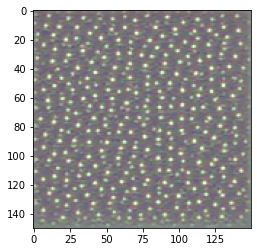

In [7]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


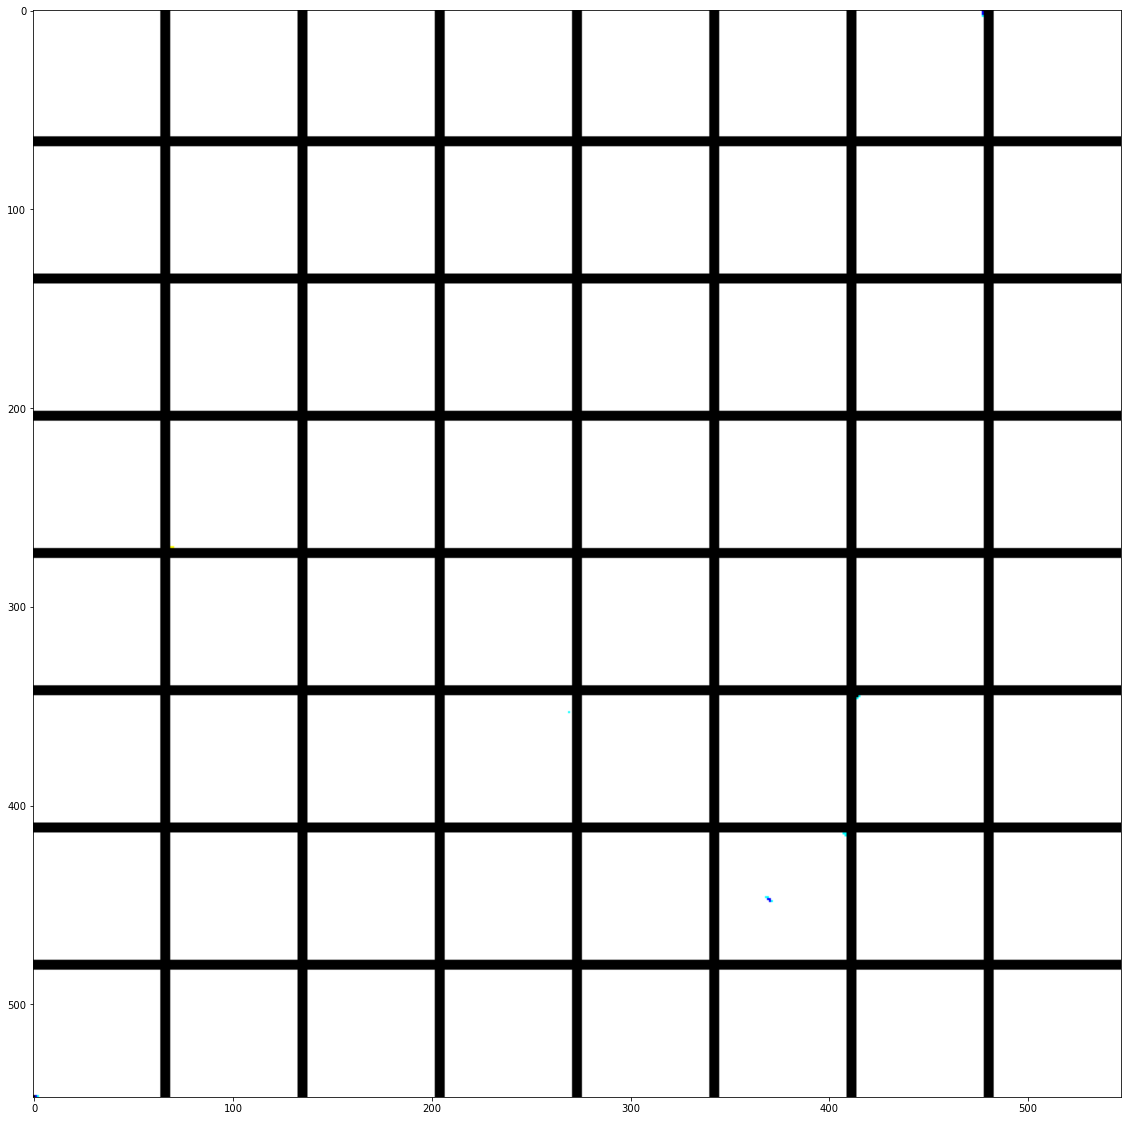

In [8]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for k in range(8):
        filter_image = generate_pattern(layer_name, i + (k * 8), size = size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = k * size + k * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start : vertical_end, :] = filter_image
plt.figure(figsize = (20, 20))
plt.imshow(results)

In [67]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights = 'imagenet')

In [68]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'C:\\Workspace\\python\\Data_Science\\dataA\\creative_commons_elephant.jpg'

# 'img' is PIL image of size 224 x 224
img = image.load_img(img_path, target_size = (224, 224))

# 'x' is a float32 NUmpy array of shaep(224, 224 , 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a 'batch'
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis = 0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [69]:
preds = model.predict(x)
print(f'Predicted: {decode_predictions(preds, top = 3)[0]}')

C:\Users\Bestc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted: [('n02504458', 'African_elephant', 0.89544886), ('n01871265', 'tusker', 0.09967599), ('n02504013', 'Indian_elephant', 0.004639546)]


In [70]:
np.argmax(preds[0])

386

In [71]:
# Grad-CAM 알고리즘 설정
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis = (0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis = -1)

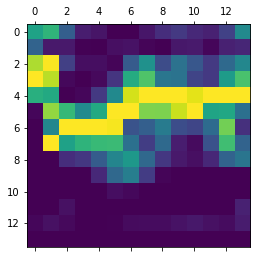

In [72]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap, 0)
plt.matshow(heatmap)

In [73]:
import cv2
img = cv2.imread('C:\\Workspace\\python\\Data_Science\\dataA\\creative_commons_elephant.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('C:\\Workspace\\python\\Data_Science\\dataA\\elephant_cam.jpg', superimposed_img)


True